# Might be useful

- list conda environments (in terminal)
    - conda info --envs
- vim cheat sheet
    - https://vim.rtorr.com/

### Check what your python path is

In [1]:
import sys
print(sys.path)

['', '/Users/Ksenia/anaconda3/lib/python36.zip', '/Users/Ksenia/anaconda3/lib/python3.6', '/Users/Ksenia/anaconda3/lib/python3.6/lib-dynload', '/Users/Ksenia/anaconda3/lib/python3.6/site-packages', '/Users/Ksenia/anaconda3/lib/python3.6/site-packages/Sphinx-1.5.1-py3.6.egg', '/Users/Ksenia/anaconda3/lib/python3.6/site-packages/aeosa', '/Users/Ksenia/anaconda3/lib/python3.6/site-packages/setuptools-27.2.0-py3.6.egg', '/Users/Ksenia/anaconda3/lib/python3.6/site-packages/IPython/extensions', '/Users/Ksenia/.ipython']


# Import all the things

In [2]:
import h5py
import netCDF4
from netCDF4 import Dataset

import numpy as np
import dask.dataframe as dd
import pandas as pd
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap

import pysal
import shapely
import pylab
import scipy
from scipy import signal
from scipy import misc

from astropy.convolution import Gaussian2DKernel, convolve

import datetime
import re

import geopandas as gpd
from shapely.geometry import Point
from shapely import prepared
# import rtree

from pyproj import Proj




# Define functions

In [3]:
def WriteRaster (raster,dst_filename,ncol,nrow,array):
        '''Create raster from array. This needs to be followed by gdal_translate command to set null value (I cannot get dataset.SetNoDataValue() to work)'''
        driver = raster.GetDriver()
        dst_ds = driver.Create(dst_filename, ncol, nrow,1,gdal.GDT_Int16)
        dst_ds.SetGeoTransform(raster.GetGeoTransform())
        srs = osr.SpatialReference()
        srs.ImportFromEPSG(4326) #WGS84 lat long.
        dst_ds.SetProjection( srs.ExportToWkt() )
        dst_ds.GetRasterBand(1).WriteArray(array)
        format = 'EHdr'
        driver = gdal.GetDriverByName(format)
        dst_ds_new = driver.CreateCopy(dst_filename, dst_ds)
        dst_ds = None

def match_counts_spatial(df_m, df_s):
    df_m['geometry'] = df_m.buffer(200)
    spatialJoin = gpd.sjoin(df_s, df_m, how = 'inner', op = 'intersects')
#     spatialJoin_final = spatialJoin.groupby([])

def remove_duplicates(numbers):
    newlist = []
    for number in numbers:
        if number not in newlist:
            newlist.append(number)
    return newlist

def gdal_error_handler(err_class, err_num, err_msg):
    errtype = {
            gdal.CE_None:'None',
            gdal.CE_Debug:'Debug',
            gdal.CE_Warning:'Warning',
            gdal.CE_Failure:'Failure',
            gdal.CE_Fatal:'Fatal'
    }
    err_msg = err_msg.replace('\n',' ')
    err_class = errtype.get(err_class, 'None')
    print( 'Error Number: %s' % (err_num))
    print( 'Error Type: %s' % (err_class))
    print( 'Error Message: %s' % (err_msg))



# Create dictionary
### - Converts between # of days after January 1st to the date
### - Do this so you can match SMAP and MEaSUREs

In [4]:
fileDateSMAP = []
fileDateMEASURES = []

latAMList =[]
longAMList = []

d = {}


filenameSM = glob.glob('/Users/Ksenia/Desktop/EarthLabPython/ImageProcessing/SoilMoisture/*.h5')
netCDFMEASURESfiles = glob.glob('/Users/Ksenia/Desktop/EarthLabPython/ImageProcessing/MEASURES/*.nc')
# ncAndH5files = filenameSM + netCDFMEASURESfiles


for fileH5 in filenameSM:
    startInd = fileH5.index('_P_')
    endInd = fileH5.index('_R')
    dateSMAP = fileH5[startInd+3:endInd]
    fileDateSMAP.append(dateSMAP)

    
for fileNC in netCDFMEASURESfiles:
    if '-M-' in fileNC: #just looking at morning for now

        #change date from number of days from beginning of year to date YYYYMMDD
        startInd = fileNC.index('SSMIS-')
        endInd = fileNC.index('-37V')
        daysFromStartOfYear = fileNC[startInd+6:endInd]

        
        dateTime = datetime.datetime.strptime(daysFromStartOfYear, '%Y%j')
        dateTimeString = dateTime.strftime("%Y-%m-%d %H:%M:%S")

        
        dateTimeSplit = re.split('-| |:', dateTimeString)

        
        dateMEASURES = ''.join(dateTimeSplit[0:3])
        fileDateMEASURES.append(dateMEASURES)
        
        
        d[dateMEASURES] = daysFromStartOfYear
      
    
print(d)

{'20150401': '2015091', '20150801': '2015213', '20160401': '2016092'}


# Test: 2D convolution

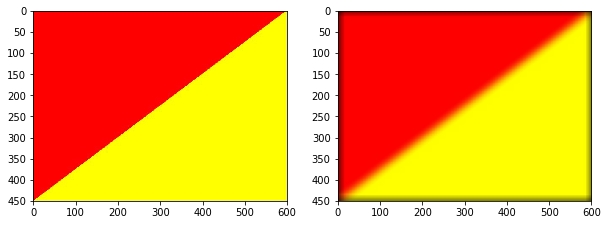

In [5]:
######################
# testing convolve2d #
######################

im = plt.imread('/Users/Ksenia/Downloads/Auto_Racing_Red_Yellow.jpg')


kernel = np.ones((30,30),np.float32)/(900)


r = scipy.signal.convolve2d(im[:,:,0], kernel, mode='same')
g = scipy.signal.convolve2d(im[:,:,1], kernel, mode='same')
b = scipy.signal.convolve2d(im[:,:,2], kernel, mode='same')


# stack the channels back into a 8-bit colour depth image and plot it
grad = np.dstack([r, g, b])
grad = (grad).astype(np.uint8) 


#plot file
fig, (ax, ax_mag) = plt.subplots(1,2, figsize=(10,10))
img2 = ax.imshow(im)
smeared = ax_mag.imshow(grad)
plt.show()

# Get data/ plot SMAP and MEaSUREs and 2D Convolution of MEaSUREs

20150401
/Users/Ksenia/Desktop/EarthLabPython/ImageProcessing/SoilMoisture/SMAP_L3_SM_P_20150401_R14010_001.h5
<class 'numpy.ndarray'>
(406, 964)


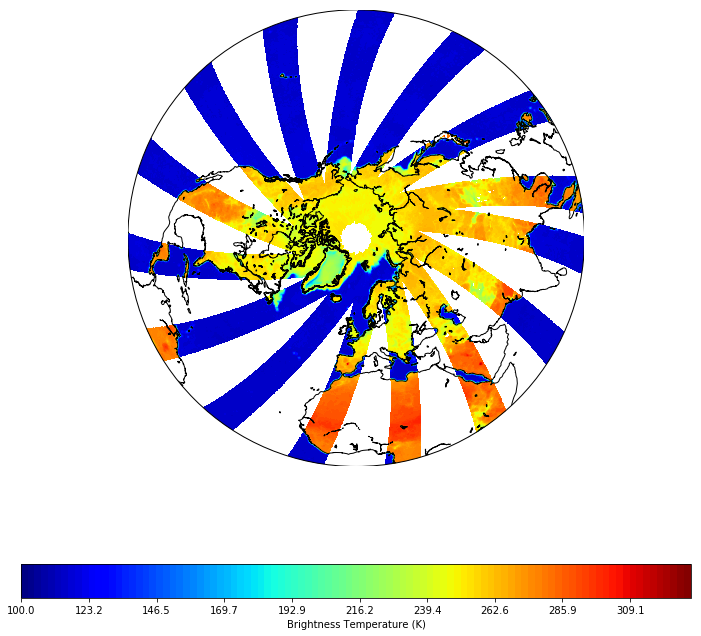

/Users/Ksenia/Desktop/EarthLabPython/ImageProcessing/MEASURES/NSIDC-0630-EASE2_N3.125km-F17_SSMIS-2015091-37V-M-SIR-CSU-v1.2.nc
<class 'numpy.ma.core.MaskedArray'>
   0     1     2     3     4     5     6     7     8     9     ...   5750  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   

   5751  5752  5753  5754  5755  5756  5757  5758  5759  
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 5760 columns]


/Users/Ksenia/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:112: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


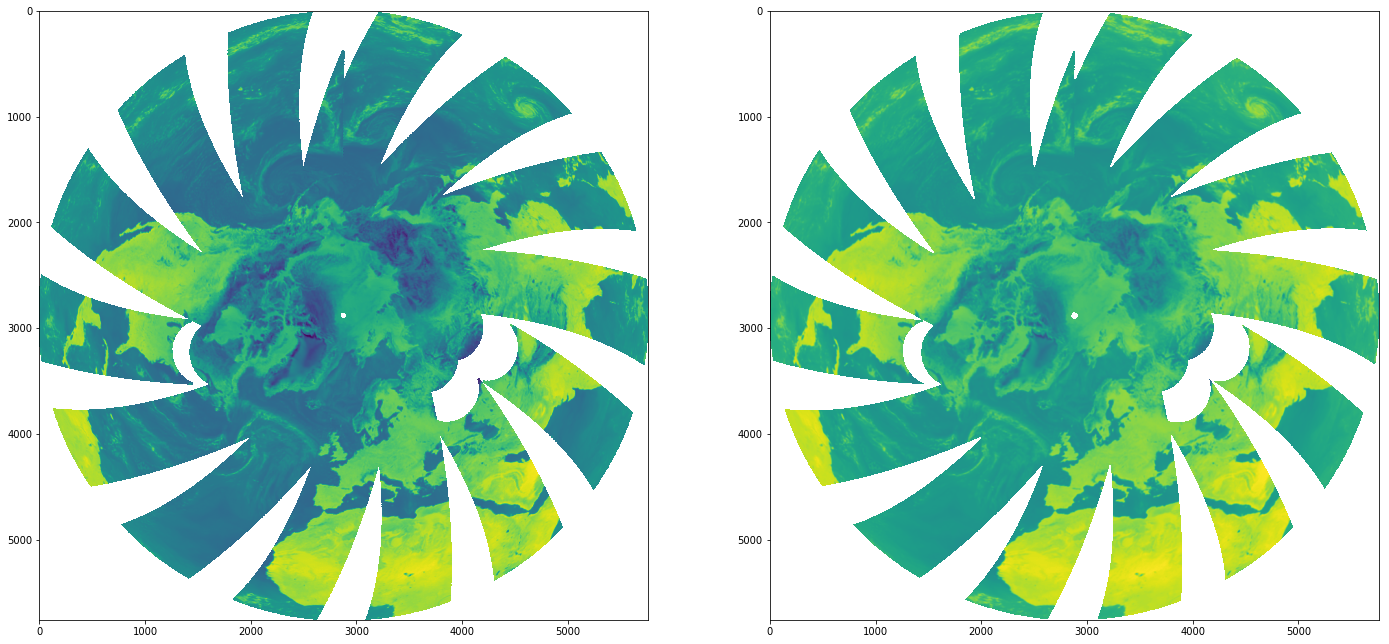

20150801
/Users/Ksenia/Desktop/EarthLabPython/ImageProcessing/SoilMoisture/SMAP_L3_SM_P_20150801_R14010_001.h5
<class 'numpy.ndarray'>
(406, 964)


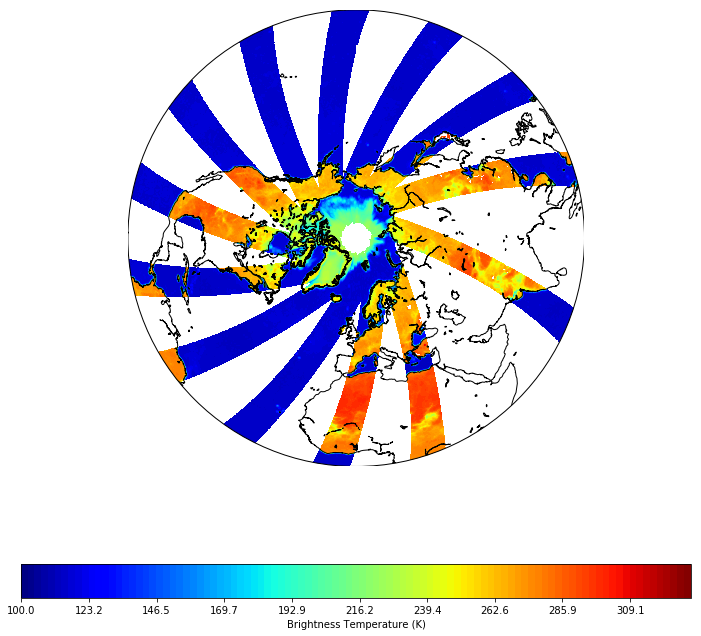

/Users/Ksenia/Desktop/EarthLabPython/ImageProcessing/MEASURES/NSIDC-0630-EASE2_N3.125km-F17_SSMIS-2015213-37V-M-SIR-CSU-v1.2.nc
<class 'numpy.ma.core.MaskedArray'>
   0     1     2     3     4     5     6     7     8     9     ...   5750  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   

   5751  5752  5753  5754  5755  5756  5757  5758  5759  
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 5760 columns]


/Users/Ksenia/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:112: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


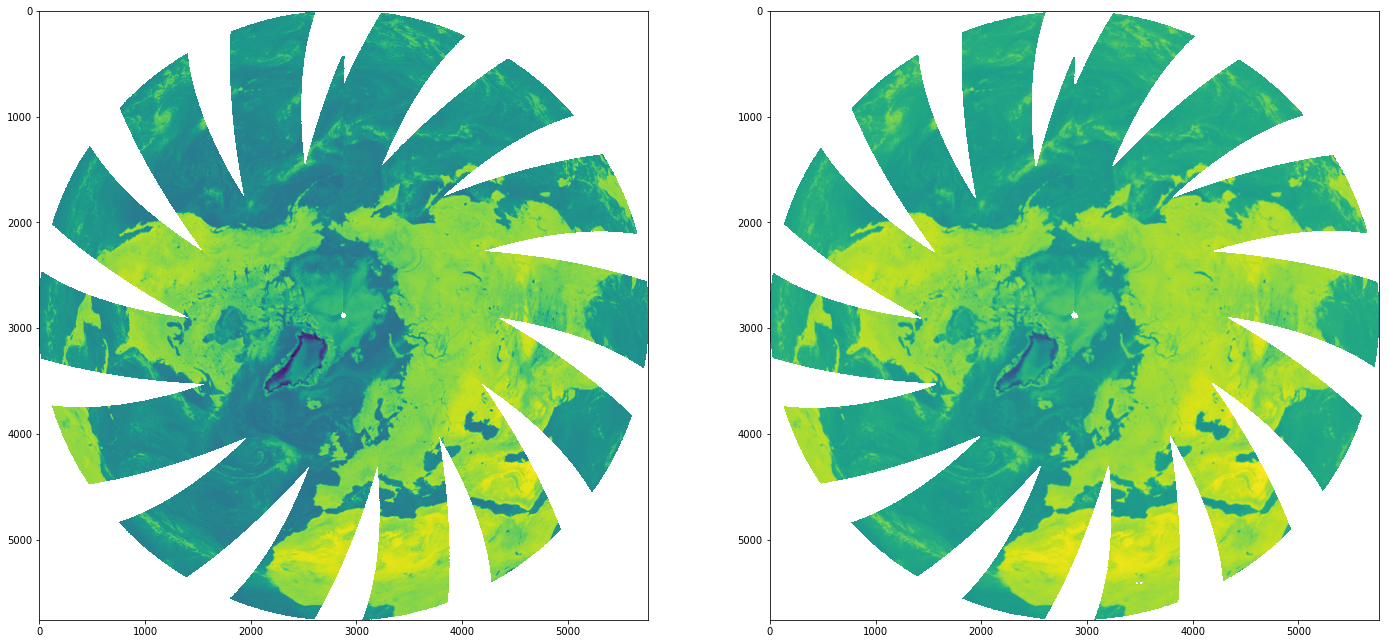

20160401
/Users/Ksenia/Desktop/EarthLabPython/ImageProcessing/SoilMoisture/SMAP_L3_SM_P_20160401_R14010_001.h5
<class 'numpy.ndarray'>
(406, 964)


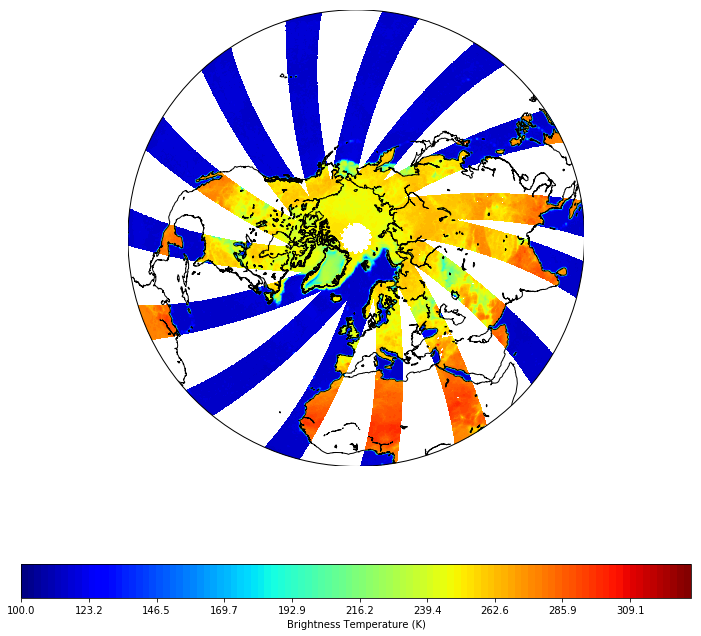

/Users/Ksenia/Desktop/EarthLabPython/ImageProcessing/MEASURES/NSIDC-0630-EASE2_N3.125km-F17_SSMIS-2016092-37V-M-SIR-CSU-v1.2.nc
<class 'numpy.ma.core.MaskedArray'>
   0     1     2     3     4     5     6     7     8     9     ...   5750  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   

   5751  5752  5753  5754  5755  5756  5757  5758  5759  
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 5760 columns]


/Users/Ksenia/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:112: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


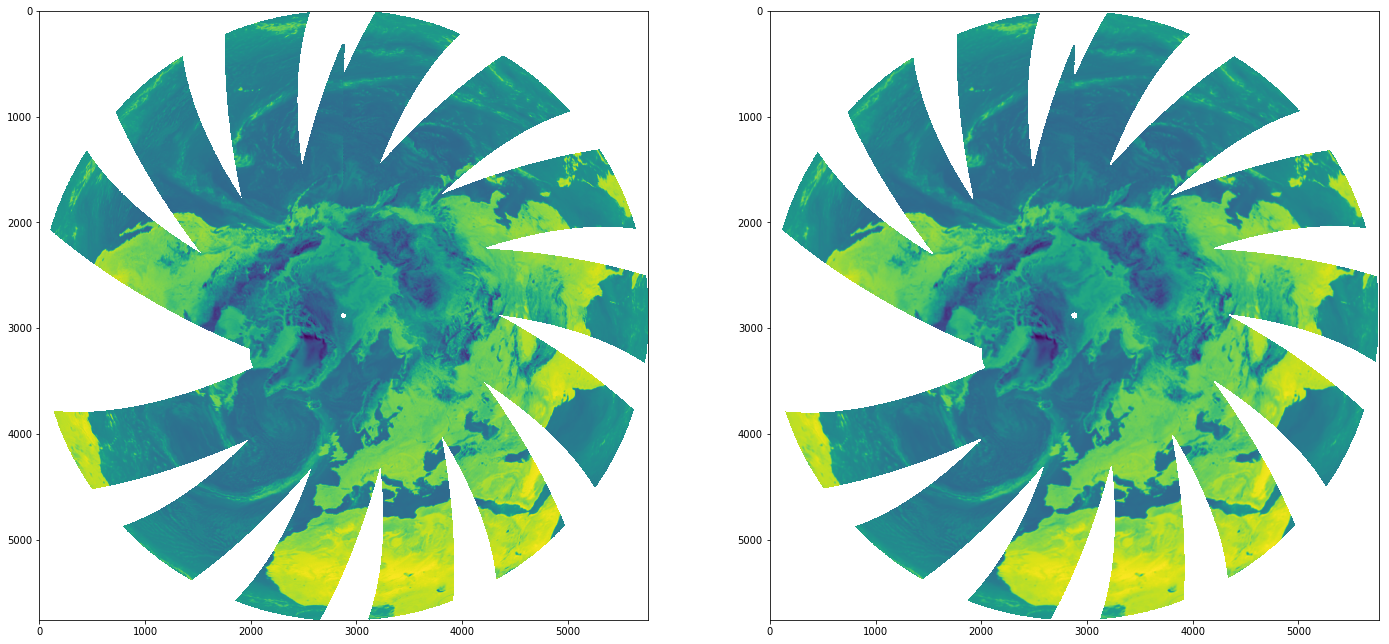

In [6]:
for i in fileDateSMAP:
    for j in fileDateMEASURES:
        if i == j:
            
            print(i)
            
            for file in filenameSM:
                if i in file:
                    with  h5py.File(file, 'r') as f:
                        
                        # Get and print list of datasets within the H5 file
                        datasetNames = [n for n in f.keys()]

                        
                        #check file
                        print(file)

                        
                        #AM dataset to plot
                #             dsetAM = f['Soil_Moisture_Retrieval_Data_AM']['soil_moisture']
                        dsetAM = f['Soil_Moisture_Retrieval_Data_AM']['tb_v_corrected']
                        tb_v_AM = dsetAM[:,:]
                        print(type(tb_v_AM))
                        
                        
                        df_TB_SMAP = pd.DataFrame(tb_v_AM)

                        
                        #get lat and long
                        latAM = np.array(f['Soil_Moisture_Retrieval_Data_AM']['latitude_centroid'])
                        longAM = np.array(f['Soil_Moisture_Retrieval_Data_AM']['longitude_centroid'])


                        fig, ax = plt.subplots(figsize=(12, 12))


                        #plot
                        m = Basemap(projection='npaeqd', round= True, boundinglat=0,lon_0=360,resolution='l')
                #             m = Basemap(projection='cyl', resolution='l', llcrnrlat=-90, urcrnrlat = 90, llcrnrlon=-180, urcrnrlon = 180)
                        m.drawcoastlines()

                    
                        #get the lat and lon grids
                #             ny = latAM[0:np.shape(latAM)[0],0]
                #             nx = longAM[0,0:np.shape(latAM)[1]]

                        #Create a new meshgrid based on the lat and lons from the data
                #             nlons, nlats = np.meshgrid(nx, ny)

                #             xAM, yAM = m(nlons, nlats)
                        xAM, yAM = m(longAM, latAM)

                    
                        #check for nan and mask nan
                        tb_v_AM[tb_v_AM == dsetAM.fillvalue] = np.nan
                        tb_v_AM = np.ma.masked_where(np.isnan(tb_v_AM), tb_v_AM)

                        #no value filler value
                        tb_v_AM[tb_v_AM == -9999.0] = np.nan
                        
                        print(tb_v_AM.shape)

                        
                        #view image
                #             im = ax.imshow(SMAM, interpolation='none', cmap=plt.cm.jet, vmin=0.01, vmax=0.55)
                #             img = ax.imshow(tb_v_AM, interpolation='none', cmap=plt.cm.jet, vmin=100, vmax=330.0) #imshow only works for rectangular images
                #             img = m.pcolormesh(xAM, yAM, tb_v_AM, cmap=plt.cm.jet, vmin=100, vmax=330.0)
                        img = m.contourf(xAM, yAM, tb_v_AM, levels=np.linspace(100,330,100), cmap=plt.cm.jet)
                        
#                         testArray = np.array(img)
                        #add colorbar
                        cbar = plt.colorbar(img,orientation="horizontal")
                #             cbar_title = str(r'Representative Soil Moisture ($cm^3/cm^3$)')
                        cbar_title = str(r'Brightness Temperature (K)')
                        cbar.ax.set_xlabel(cbar_title)

                        plt.show()
                        
            for key in d:
                if i == key:
                    for ncFile in netCDFMEASURESfiles:
                        if d[key] in ncFile:
                            with  Dataset(ncFile, mode='r') as nc:
                                
                                #check file
                                if '-M-' in ncFile:
                                    
                                    print(ncFile)

                                    TB = nc.variables['TB'][:]
                                    TBSqueezed = np.squeeze(TB)
                                    print(type(TBSqueezed))
                                    
                                    
                                    df_TB_MEASURES = pd.DataFrame(TBSqueezed)
                                    print(df_TB_MEASURES.head())
                                    print(df_TB_MEASURES.shape)
                                    gdf = gpd.read_file('/Users/Ksenia/Desktop/EarthLabPython/ImageProcessing/EASE2_fishnet_vectors/EASE2_N3_125km_fishnet/EASE2_N3_125km_fishnet.shp')
                                    print(gdf.head(5))
                                    print(gdf.shape)
#                                     print(gdf[geometry] - 1562)
                                    
    
                                    #get dimensions for average -> Needed for convolution
                                    size = TBSqueezed.shape
                                    row = size[0]
                                    col = size[1]
                                    total = row * col
                                      
                            
                                    #no value filler value
                                    TBSqueezed[TBSqueezed == 0] = np.nan

                                    
                                    kernel = np.ones((12,12),np.float32)/(144) 
                                    #plot file
                                    grad = signal.convolve2d(TBSqueezed, kernel, mode='same')
                                    
                                    
                                    fig, (ax, ax_mag) = plt.subplots(1,2, figsize=(24, 24))
                                    img2 = ax.imshow(TBSqueezed[:,:])
                                    smeared = ax_mag.imshow(grad)
                                    
                                    plt.show()
                                    
# WriteRaster ('/User/Ksenia/Downloads/NE2_50M_SR_W/NE2_50M_SR_W.prj','test_raster_lowres',4000,4000,tb_v_AM)
# WriteRaster ('/User/Ksenia/Desktop/earthlab/countries/ne_110m_admin_0_countries.shp','test_raster_highres',4000,4000,TBSqueezed)
# match_counts_spatial(test_raster_lowres, test_raster_highres)
# print(tb_v_AM)
        

# If gdal install issues:

For error:

	ImportError: dlopen(/Users/Ksenia/anaconda3/lib/python3.6/site-packages/osgeo/_gdal.cpython-36m-darwin.so, 2): Library not loaded: @rpath/libgdal.20.dylib
	Referenced from: /Users/Ksenia/anaconda3/lib/python3.6/site-packages/osgeo/_gdal.cpython-36m-darwin.so
 	Reason: Incompatible library version: _gdal.cpython-36m-darwin.so requires version 23.0.0 or later, but libgdal.20.dylib provides version 22.0.0

1) Uninstall and reinstall using:	  

    conda install -c conda-forge gdal

For me, the error changed to:

	ImportError: dlopen(/Users/Ksenia/anaconda3/lib/python3.6/site-packages/osgeo/_gdal.cpython-36m-darwin.so, 2): Library not loaded: @rpath/libssh2.1.dylib
	Referenced from: /Users/Ksenia/anaconda3/lib/libgdal.20.dylib
	Reason: image not found

2)     In terminal: install dependency that’s causing the problem.

    brew install libssh2

3)     Run code again see if the error changed or went away

4)     Continue installing dependencies until no more error. 


In [7]:
#Need for changing dimensions - gdal.Warp
import gdal

# Change dimensions of SMAP data

- Change from EPSG:6933 (SMAP) to EPSG: 6931 (Northern Hemisphere)
    - The only difference is that the original is that the SMAP data is global and the northern hemisphere is just half of the globe
    
- After supposedly changing the dimensions, it doesn't appear that it made any sort of difference
    - Investigate further
    
### See projection of SMAP files

- not necessary

In [8]:
 for file in filenameSM:
        hdf_ds = gdal.Open(file,  gdal.GA_ReadOnly)

        # this is just a string of the name of the subdataset
        b3_string = hdf_ds.GetSubDatasets()[4][0]

        # open the subdataset
        sds_b3 = gdal.Open(hdf_ds.GetSubDatasets()[4][0])

        # get the projection
        proj = sds_b3.GetProjection()
        
        print(proj)
        print(' ')


GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]
 
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]
 
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]
 


### Warp or Transform or something

- force change projection + dimensionality

20150401
/Users/Ksenia/Desktop/EarthLabPython/ImageProcessing/SoilMoisture/SMAP_L3_SM_P_20150401_R14010_001.h5
Before
(406, 964)


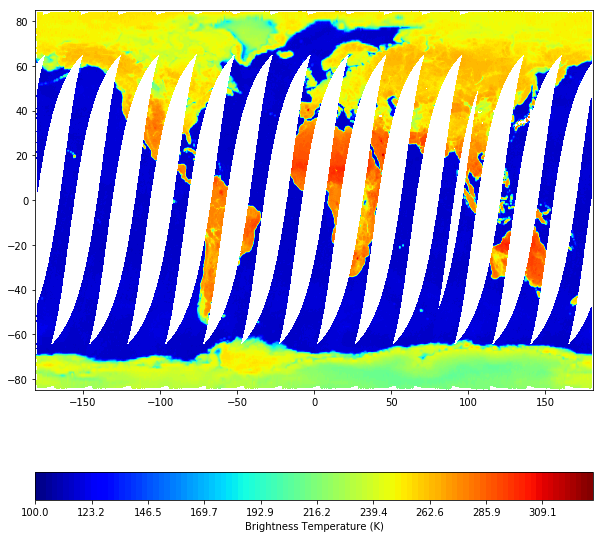

Before Warp
Warp worked
After
(406, 964)


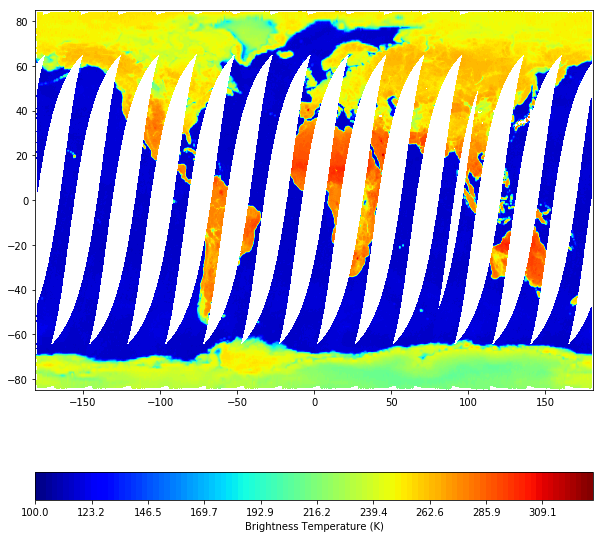

20150801
/Users/Ksenia/Desktop/EarthLabPython/ImageProcessing/SoilMoisture/SMAP_L3_SM_P_20150801_R14010_001.h5
Before
(406, 964)


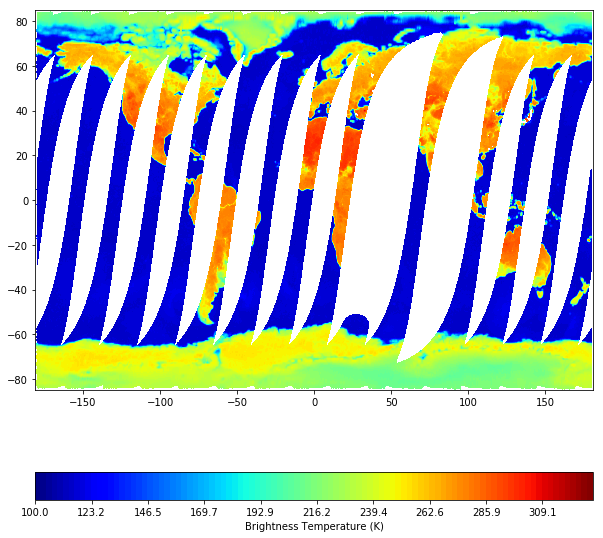

Before Warp
Warp worked
After
(406, 964)


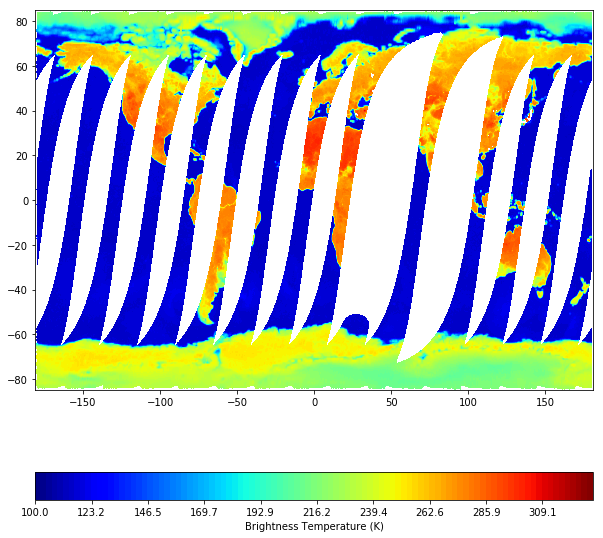

20160401
/Users/Ksenia/Desktop/EarthLabPython/ImageProcessing/SoilMoisture/SMAP_L3_SM_P_20160401_R14010_001.h5
Before
(406, 964)


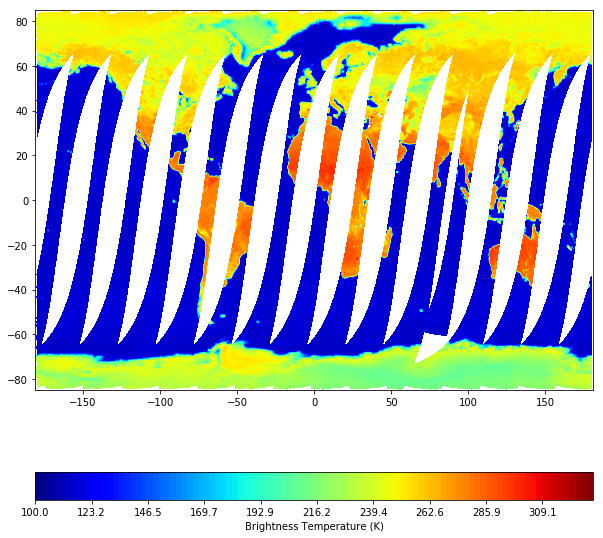

Before Warp
Warp worked
After
(406, 964)


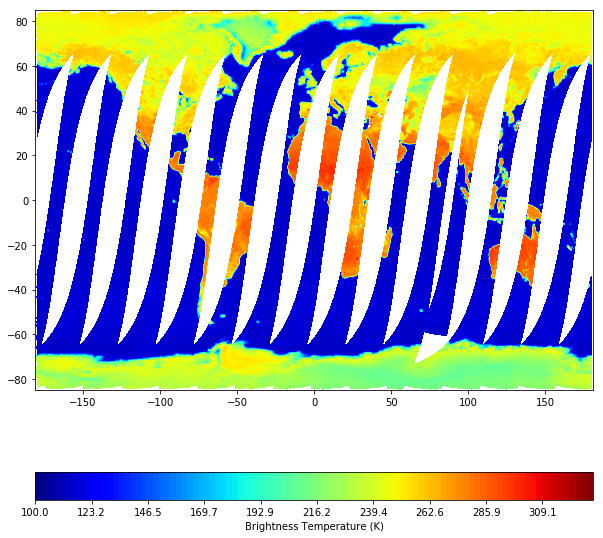

Done


In [9]:
#for changing the x and y scale of the image
import pylab
import scipy.misc


for i in fileDateSMAP:
    for j in fileDateMEASURES:
        if i == j:
            
            print(i)
            
            for file in filenameSM:
                if i in file:
                    with  h5py.File(file, 'r') as f:
                        
                        #PRINT: Original picture first
                        #check file
                        print(file)
                        
                        dsetAM = f['Soil_Moisture_Retrieval_Data_AM']['tb_v_corrected']
                        tb_v_AM = dsetAM[:,:]
#                         scipy.misc.imsave('/Users/Ksenia/Desktop/tb.jpg', tb_v_AM)
                        
                        
                        #get lat and long
                        latAM = np.array(f['Soil_Moisture_Retrieval_Data_AM']['latitude_centroid'])
                        longAM = np.array(f['Soil_Moisture_Retrieval_Data_AM']['longitude_centroid'])


                        fig, ax = plt.subplots(figsize=(10, 10))


                        #check for nan and mask nan
                        tb_v_AM[tb_v_AM == dsetAM.fillvalue] = np.nan
                        tb_v_AM = np.ma.masked_where(np.isnan(tb_v_AM), tb_v_AM)

                        #no value filler value
                        tb_v_AM[tb_v_AM == -9999.0] = np.nan
                        
                        ax = plt.subplot(111)
                        img = ax.contourf(longAM, latAM, tb_v_AM, levels=np.linspace(100,330,100), cmap=plt.cm.jet)
                        pylab.xlim([-181,181])
                        pylab.ylim([-85,85])
                        
                         #add colorbar
                        cbar = plt.colorbar(img,orientation="horizontal")
                        cbar_title = str(r'Brightness Temperature (K)')
                        cbar.ax.set_xlabel(cbar_title)

                        print('Before')
                        print(tb_v_AM.shape)
                        plt.show(1)
                        
                        
                        #------------------------------------------------

                        #PRINT: Warped picture first
                        print('Before Warp')
                        test = gdal.Warp('', file, srcSRS = 'EPSG:6933', dstSRS = 'EPSG:6931')
#                         test = gdal.AutoCreateWarpedVRT(file, 'EPSG:6933', 'EPSG:3995')
#                         gdal.ReprojectImage(file, test, 'EPSG:6933', 'EPSG:3995')
#                         gdal.Warp('', file, srcSRS = 'EPSG:6333', dstSRS = 'EPSG:6931')
                        print('Warp worked')
                        
                        dsetAMWarped = f['Soil_Moisture_Retrieval_Data_AM']['tb_v_corrected']
                        tb_v_AMWarped = dsetAMWarped[:,:]
#                         scipy.misc.imsave('/Users/Ksenia/Desktop/warped.jpg', tb_v_AMWarped)
        
                        #get lat and long for warped
                        latAMWarped = np.array(f['Soil_Moisture_Retrieval_Data_AM']['latitude_centroid'])
                        longAMWarped = np.array(f['Soil_Moisture_Retrieval_Data_AM']['longitude_centroid'])


                        fig, ax2 = plt.subplots(figsize=(10, 10))

                    
                        #check for nan and mask nan
                        tb_v_AMWarped[tb_v_AMWarped == dsetAMWarped.fillvalue] = np.nan
                        tb_v_AMWarped = np.ma.masked_where(np.isnan(tb_v_AMWarped), tb_v_AMWarped)

                        #no value filler value
                        tb_v_AMWarped[tb_v_AMWarped == -9999.0] = np.nan
                        
                        ax2 = plt.subplot(111)
                        img2 = ax2.contourf(longAMWarped, latAMWarped, tb_v_AMWarped, levels=np.linspace(100,330,100), cmap=plt.cm.jet)
                        pylab.xlim([-181,181])
                        pylab.ylim([-85,85])

                        #add colorbar
                        cbar = plt.colorbar(img2,orientation="horizontal")
                        cbar_title = str(r'Brightness Temperature (K)')
                        cbar.ax.set_xlabel(cbar_title)
                        
                        print('After')
                        print(tb_v_AMWarped.shape)
                        plt.show(2)
print('Done')

# Import dependencies for cetbtools

In [10]:
import osgeo
import affine

# Get cetbtools to actually work

- ???

In [11]:
from cetbtools.ease2conv import Ease2Transform

ModuleNotFoundError: No module named 'cetbtools.ease2conv'

# Imagery Resampling of MEaSUREs data

- from ~6000x6000 to ???
- is using zoom correct?

In [ ]:
import scipy.ndimage

for ncFile in netCDFMEASURESfiles:
        with  Dataset(ncFile, mode='r') as nc:
            #check file
            if '-M-' in ncFile:

                print(ncFile)

                TB = nc.variables['TB'][:]
                TBSqueezed = np.squeeze(TB)
                print(type(TBSqueezed))

                #no value filler value
                TBSqueezed[TBSqueezed == 0] = np.nan
                
                resampled = scipy.ndimage.zoom(TBSqueezed, 0.1, order=0)

                fig, (ax, ax_mag) = plt.subplots(1,2, figsize=(24, 24))
                img2 = ax.imshow(TBSqueezed[:,:])
                smeared = ax_mag.imshow(resampled)

                plt.show()

### Notes
    - Interpolation: make sure maps in same projection and same dimensions <-- DONE
    - Do another 2D convolution bw SMAP and HD <-- Is this necessary??

### Not really doing this anymore?? Code lower down
    - Convert grid data to something else <-- google "scipy convert to spatial"
    - Then spatial join
    
### Doing this instead
    - SMAP - change dimensions 
        - ID epsg grid corresponding to SMAP EASE grid projection: EPSG 6933
        - find epsg ID for northern hemisphere ease grid projection: EPSG 6931
        - gdal warp or translate
        - save out as geotiff
    - Resample the measures (to 36 km)  by doing nearest neighbor - imagery resampling
         - write out as geotiff
         - use warp or translate to resample

    - index SMAP for valid values (complex find)


# Test: Get Index + Match values from list to matrix

In [ ]:
###################################################################
# testing match values from list to values in matrix -> get index #
###################################################################

testMatList = [[1,2,2],[2,3,3],[3,4,4]]
testMat = np.asarray(testMatList)
testList = [2, 2, 3]
testArray = np.asarray(testList)

print(testList)
print(testMat)


# for val in testMat:
for val in remove_duplicates(testList):
    print('In loop')
#     print(testMat)
    print(val)
    print([(ix,iy) for ix, row in enumerate(testMat) for iy, i in enumerate(row) if i == val])

# Spatial Join 
- Not needed for now

In [ ]:
########################## 
# for spatial join:      #
# get TB, lat and long   #
# of MEaSUREs dataset    #
##########################

import time
import datetime
import folium
import gmplot
import pickle
import os
from sqlalchemy import create_engine # database connection
# import gmaps

#store TB data
elementList = []

#TODO: decide if this dataframe is necessary
TB_Location_DF = gpd.GeoDataFrame(columns=["TB (K)", "Lat", "Long"])

#create SQL database (maybe easier to access than pandas df..? I might be confused)
# disk_engine = create_engine('sqlite:///MEaSUREs_TB.db') # Initializes database with filename MEaSUREs_TB.db in current directory

#Converts from x and y to lat and long or vise versa
pnyc = Proj(
    proj = 'laea', #lambert_azimuthal_equal_area
    datum = 'WGS84', #datum 
#     lat_1 = 40.666667,
#     lat_2 = 41.033333,
    lat_0 = 90.0, #latitude of projection origin
    lon_0 = 0.0, #longitude of projection origin 
    x_0 = 0.0, #false easting
    y_0 = 0.0) #false northing

# for ncFile in netCDFMEASURESfiles:

# testing with one file
ncFile = '/Users/Ksenia/Desktop/EarthLabPython/ImageProcessing/MEASURES/NSIDC-0630-EASE2_N3.125km-F17_SSMIS-2015091-37V-E-SIR-CSU-v1.2.nc'

#open file
with Dataset(ncFile, mode='r') as nc:
    startTime = time.time()
    # get list of x variables (unit: meters)
    xVars = nc.variables['x'][:]

    
    # get list of y variables (unit: meters)
    yVars = nc.variables['y'][:]
    yVars = np.insert(yVars, 0,0) #add 0 to beggining of array so that dimensions match
    
    
    # get temperature brightness data
    tb = nc.variables['TB'][:]
    
    # squeeze 3D array to 2D array (don't need 3D -- unnecessary data for this project)
    tbSqueezed = np.squeeze(tb)
    print("Got data and squeezed")
    print("Time: ", time.time() - startTime)
    
    # insert x data as first row to array
    tbX = np.insert(tbSqueezed, 0, xVars, 0)
    
    # insert y data as first col to array
    tbXY = np.insert(tbX, 0, yVars, 1)
    
    print("Added row and column")
    print("Time: ", time.time() - startTime)
    
    
    #check
    #only create test file if it doesn't already exist (creating file NOT necessary)
    if not os.path.isfile('/Users/Ksenia/Desktop/file.txt'):
        np.savetxt('/Users/Ksenia/Desktop/file.txt', tbXY, fmt='%.1f', delimiter=',')
    print("file exists")
    print("Time: ", time.time() - startTime)

    print("Starting element list loop")
    print("Time: ", time.time() - startTime)
    
    for i in tbXY[1:-1,1:-1]:
        for element in np.nditer(i):
            if element != 0:
                elementList.append(element) # ~20 million elements
                
    print("Finished element list loop") 
    print("Time: ", time.time() - startTime)
    
#     np.savetxt('/Users/Ksenia/Desktop/fileElemList.txt', elementList, fmt='%.1f', delimiter=',')
    print("Starting count")
    print("Time: ", time.time() - startTime)
    
    count = 0
    for val in remove_duplicates(elementList):
        count += 1
        
    print("End loop")
    print("Time: ", time.time() - startTime)
    print(count)
    
#         print([(ix,iy) for ix, row in enumerate(tbXY) for iy, i in enumerate(row) if i == val])
    
#     np.savetxt('/Users/Ksenia/Desktop/fileIndex.txt', index, fmt='%.1f', delimiter=',')
    

    TB_Location_DF["TB (K)"] = elementList
    
    
    
    #Add DF to SQL database
#     TB_Location_DF.to_sql('data', disk_engine, if_exists='append')

#     for xIter in xVarsList:
#         x = [xIter]
#         for yIter in yVarsList:
#             y = [yIter]
#             lon, lat = pnyc(x,y,inverse=True)
#             a, b = map(lon, lat)

#             map.plot(a, b, 'bo', markersize=24)

#     plt.show()
#             # mapit = None
            # latlon = [ (lon, lat)]
            # for coord in latlon:
#                 mapit = folium.Map(location=[lon, lat] ) #[lon, lat]
#                 folium.Marker(location=[lon, lat]).add_to( mapit )

# map.save('/Users/Ksenia/Desktop/testLatLonMap.html')

print("Done")

# Error handler
 - Don't think this is supper necessary

In [ ]:
if __name__=='__main__':

    # install error handler
    gdal.PushErrorHandler(gdal_error_handler)

    # Raise a dummy error
    gdal.Error(1, 2, 'test error')

    #uninstall error handler
    gdal.PopErrorHandler()

###### This style of commenting only works when it's above code I guess

In [ ]:
"""
testing comment. test test
"""
print('test')
